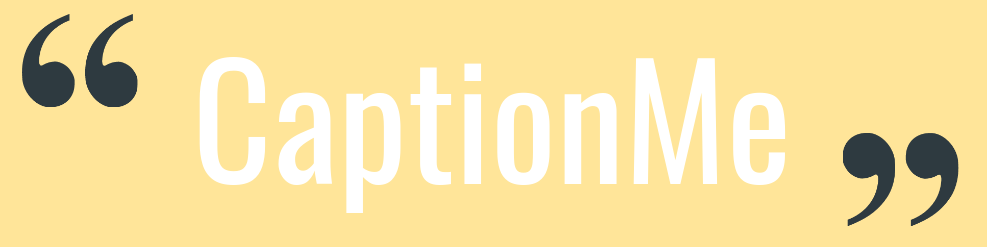

# CaptionMe Project


---


We are working on a project which has the goal to generate some categories about a given image and  reciprocally.
To achieve this project we have listed the following steps :

## 1. Download the dataset of Flickr30K from Kaggle website

 * Download the datset using this URL :
 https://www.kaggle.com/hsankesara/flickr-image-dataset
 * Move it to your Drive 
 * Extract the data - unzip the folder - even if it takes a looooong time
 * Create a shortcut of `archive` into you `/content/drive/MyDrive`


## 2. If you want to test the model:
 * Go down to the section 8 and follow the steps

---


<u>Note</u> :

<b>Flickr30K</b> contains <b>31783 images</b> with <b>5 different comments</b> corresponding to them. The idea there is to take a part of the dataset at the first 8000 images in total for those reasons :
* The memory capacity of Disk in Google Drive, Google Colab : we tested the way with the whole 31783 images dataset and taking only 1 comment per image, that is to say a total of 31783 comments. The result was very bad, around O.38 %  of accurray even trying to tune the model.
* The model of text generation should be trained on various comments per image to be more accurate and in order to reduce the loss and val loss. 

# 1 - Hardware

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun May 30 10:57:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# 2 - Dataset Management

In [ ]:
# The first step is to mount our drives :
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Paths to the dataset
OWNER_DRIVE = "Merieme"
FLICKR_SEED_PATH_DIR = "/content/drive/MyDrive/archive/flickr30k_images/"
FLICKR_PATH_CSV = FLICKR_SEED_PATH_DIR + "results.csv"
FLICKR_PATH_DIR = FLICKR_SEED_PATH_DIR + "flickr30k_images/"

FLICKR_PATH_DIR_8K_5C_METHOD2 = FLICKR_SEED_PATH_DIR + "flickr8K_5C_Method2/"
FLICKR_PATH_DIR_8K_5C_METHOD2_MODEL = FLICKR_PATH_DIR_8K_5C_METHOD2 + "model/"
FLICKR_PATH_DIR_8K_5C_METHOD2_MODEL_CHECKPOINTS_DIR = FLICKR_PATH_DIR_8K_5C_METHOD2_MODEL + "model_generation_sentences/"

GLOVE_PATH = FLICKR_PATH_DIR_8K_5C_METHOD2 + 'glove6b/'


# 3 - Pre-processing Data

In [ ]:
import pandas as pd
import os
import numpy as np
import pickle
from pickle import dump
from datetime import datetime
import time
from IPython.display import Image
import matplotlib.pyplot as plt

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint

<u>Way to proceed</u> :</br>
There are to ways to proceed in this project :
* <b>The first considers 5 comments per image</b> but we are not going to use this way because of the lack of memory :
   * All the images in the dataset has both <b>5 different comments</b> and <b>1 image in the folder</b>

   * The `flickr_csv` is a Dataframe containing the flickr30k dataset and other columns , the whole sorted by `image_name` column. 
* <b>The second considers 1 comment per image</b> and we are going to use this way fisrt !

We will thus condiser <b>`8000 images and 8000 * 5 = 40000 coments`</b>

In [ ]:
# Checkout the labels of our data

flickr_csv = pd.read_csv(FLICKR_PATH_CSV, error_bad_lines=False, sep="|")
 
# We notice that there are spaces in the features names : let's removing them
# Columns : 'image_name', 'comment_number', 'comment'
flickr_csv.columns = [col.strip() for col in flickr_csv.columns]

# We notice that there are spaces in the leading of cells : let's removing them
for col in flickr_csv.columns:
  flickr_csv[col] = flickr_csv[col].apply(lambda x: str(x).lstrip())

# Put all the comments into lowercase
flickr_csv['comment'] = flickr_csv['comment'].apply(lambda x: x.lower())


# Add new column 'image_name_process' by concatenating 'image_name' without the extension '.jpg' and the 'comment_number'
flickr_csv["image_name_process"] = flickr_csv.apply(lambda row: row["image_name"].split(".")[0] + "." + row["comment_number"], axis=1)

# Sort flickr_csv by 'image_name_process'
flickr_csv = flickr_csv.sort_values("image_name_process")

# Keep only 8090 lines
flickr_csv = flickr_csv.loc[:8000*5-1]

flickr_csv.head()

,image_name,comment_number,comment,image_name_process
0,1000092795.jpg,0,two young guys with shaggy hair look at their ...,1000092795.0
1,1000092795.jpg,1,"two young , white males are outside near many ...",1000092795.1
2,1000092795.jpg,2,two men in green shirts are standing in a yard .,1000092795.2
3,1000092795.jpg,3,a man in a blue shirt standing in a garden .,1000092795.3
4,1000092795.jpg,4,two friends enjoy time spent together .,1000092795.4


In [ ]:
flickr_csv.tail()

,image_name,comment_number,comment,image_name_process
39995,2702682262.jpg,0,a tattooed man sitting on a sidewalk has pulle...,2702682262.0
39996,2702682262.jpg,1,"a man sits on the sidewalk , head in hands and...",2702682262.1
39997,2702682262.jpg,2,dejected man sits crossed-legged with head in ...,2702682262.2
39998,2702682262.jpg,3,a man sitting on sidewalk with shirt over his ...,2702682262.3
39999,2702682262.jpg,4,depressed man who does not know what to do .,2702682262.4


Verifying if all the `image_name` in the `Dataframe flickr_csv` have an image in the folder `FLICKR_PATH_DIR`.

In [ ]:
# Verfify if an image_name corresponds to an existing image
image_name_in_folder = os.listdir(FLICKR_PATH_DIR)

cpt_index_images_name_to_drop = 0

for index, row in flickr_csv.iterrows():
  if row['image_name'] not in image_name_in_folder:
    cpt_index_images_name_to_drop += 1

if cpt_index_images_name_to_drop == 0:
  print("All image_name values in the dataset has an image in the folder !")
else:
  print("Some image_name values in the dataset hasn't an image in the folder !")

All image_name values in the dataset has an image in the folder !


Verifying if all the `image_name` in the `Dataframe flickr_csv` have 5 comments.

In [ ]:
# Verify how many comments are there for every image
flickr_gbcount = flickr_csv.groupby("image_name").count()

# Count the number of 'image_name_process' after groupby and count inferior to 5
cpt = 0

for index, row in flickr_gbcount.iterrows():
  if row["image_name_process"] == 5:
    cpt += 1

if len(flickr_gbcount) == cpt:
  print("All the images have 5 comments !")
else:
  print("Some images have less that 5 comments !\nThis must be due to the reduction number to 1 of comments per image...")


All the images have 5 comments !


In [ ]:
flickr_gbcount.head()

,comment_number,comment,image_name_process
image_name,,,
1000092795.jpg,5,5,5
10002456.jpg,5,5,5
1000268201.jpg,5,5,5
1000344755.jpg,5,5,5
1000366164.jpg,5,5,5


<u>Remove punctuation</u> :

Punctuation can provide grammatical context to a sentence which supports our understanding. But for our vectorizer which counts the number of words and not the context, it does not add value, so we remove all special characters. eg: How are you?->How are you

In [ ]:
import string

# Function to remove the punctuation
def remove_punctuation(text):
  """
  Takes a text and remove its punctuation.
  """
  text_without_punct = "".join([char for char in text if char not in string.punctuation])

  return text_without_punct

flickr_csv["comment_text_clean"] = flickr_csv["comment"].apply(lambda x: remove_punctuation(str(x)))

flickr_csv.head()

,image_name,comment_number,comment,image_name_process,comment_text_clean
0,1000092795.jpg,0,two young guys with shaggy hair look at their ...,1000092795.0,two young guys with shaggy hair look at their ...
1,1000092795.jpg,1,"two young , white males are outside near many ...",1000092795.1,two young white males are outside near many b...
2,1000092795.jpg,2,two men in green shirts are standing in a yard .,1000092795.2,two men in green shirts are standing in a yard
3,1000092795.jpg,3,a man in a blue shirt standing in a garden .,1000092795.3,a man in a blue shirt standing in a garden
4,1000092795.jpg,4,two friends enjoy time spent together .,1000092795.4,two friends enjoy time spent together


In [ ]:
flickr_csv["comment"][0]

'two young guys with shaggy hair look at their hands while hanging out in the yard .'

Next, we create a dictionary named “descriptions” which contains the name of the image as keys and a list of the 5 captions for the corresponding image as values.

In [ ]:
descriptions = dict()

for index, row in flickr_csv.iterrows():
  image_name = row['image_name'].split(".")[0]
  desc = row["comment_text_clean"]
  if image_name not in descriptions:
    descriptions[image_name] = []
  
  descriptions[image_name].append(desc)

descriptions["1000092795"]

['two young guys with shaggy hair look at their hands while hanging out in the yard ',
 'two young  white males are outside near many bushes ',
 'two men in green shirts are standing in a yard ',
 'a man in a blue shirt standing in a garden ',
 'two friends enjoy time spent together ']

Next, we create a vocabulary of all the unique words present across all the 8000*5 (i.e. 40000) image captions in the data set. We have 8828 unique words across all the 40000 image captions.

In [ ]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 10773


Now let’s save the image id’s and their new cleaned captions in the same format as the token.txt file:-

In [ ]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [ ]:
new_descriptions.split("\n")[0]

'1000092795 two young guys with shaggy hair look at their hands while hanging out in the yard '

Next, we load all the 6000 training image id’s in a variable train.

In [ ]:
# Contains all the images_name without the ".png" for the training set
train = set([imageName.split(".")[0] for imageName in flickr_csv["image_name"].loc[:30000-1]])
print("Varibale`train` has : {} values".format(len(train)))

# Contains all the images_name without the ".png" for the testing set
test = set([imageName.split(".")[0] for imageName in flickr_csv["image_name"].loc[30000:40000-1]])
print("Varibale`train` has : {} values".format(len(test)))

Varibale`train` has : 6000 values
Varibale`train` has : 2000 values


Now we save all the training and testing images in train_img and test_img lists respectively. We verify again if all the `image_name` of whole train and test dataset are available on the image directory and thus verify if all the `image_name` are mapped in the image directory.

In [ ]:
import glob

images = glob.glob(FLICKR_PATH_DIR + '*.jpg')
train_images = train
train_img = []

for image in images: 
    if image[len(FLICKR_PATH_DIR):].split(".")[0] in train_images:
      train_img.append(image)

test_images = test
test_img = []
for image in images: 
    if image[len(FLICKR_PATH_DIR):].split(".")[0] in test_images: 
      test_img.append(image)

In [ ]:
print("Number of training images : {}".format(len(train_img)))
print("Number of test images : {}".format(len(test_img)))

Number of training images : 6000
Number of test images : 2000


Now, we load the descriptions of the training images into a dictionary. However, we will add two tokens in every caption, which are ‘startseq’ and ‘endseq’.

In [ ]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

In [ ]:
train_descriptions[list(train_descriptions.keys())[0]]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in a yard endseq',
 'startseq a man in a blue shirt standing in a garden endseq',
 'startseq two friends enjoy time spent together endseq']

Create a list of all the training captions.

In [ ]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [ ]:
all_train_captions[:5]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in a yard endseq',
 'startseq a man in a blue shirt standing in a garden endseq',
 'startseq two friends enjoy time spent together endseq']


To make our model more robust we will reduce our vocabulary to only those words which occur at least 10 times in the entire corpus.

In [ ]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 2100


Now we create two dictionaries to map words to an index and vice versa. Also, we append 1 to our vocabulary since we append 0’s to make all captions of equal length.

In [ ]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [ ]:
print("Size of vocabulary : {}".format(vocab_size))
print("`ixtoword` = {}".format(len(ixtoword)))
print("`wordtoix` = {}".format(len(wordtoix)))

Size of vocabulary : 2101
`ixtoword` = 2100
`wordtoix` = 2100


In [ ]:
print("ixtoword -> {} : {}".format(list(ixtoword.keys())[0], ixtoword[list(ixtoword.keys())[0]]))
print("wordtoix -> {} : {}".format(list(wordtoix.keys())[0], wordtoix[list(wordtoix.keys())[0]]))

ixtoword -> 1 : startseq
wordtoix -> startseq : 1


Hence now our total vocabulary size is 2101.
We also need to find out what the max length of a caption can be since we cannot have captions of arbitrary length.

In [ ]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 80


## Glove Embeddings

Word vectors map words to a vector space, where similar words are clustered together and different words are separated. The advantage of using Glove over Word2Vec is that GloVe does not just rely on the local context of words but it incorporates global word co-occurrence to obtain word vectors.

The basic premise behind Glove is that we can derive semantic relationships between words from the co-occurrence matrix. For our model, we will map all the words in our 38-word long caption to a 200-dimension vector using Glove.

```python
  dict(string : list(float32))  glov6d
```

In [ ]:
embeddings_index = {} 
f = open(os.path.join(GLOVE_PATH, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [ ]:
print("Embeddings index \n {} : {}".format(list(embeddings_index.keys())[0], embeddings_index[list(embeddings_index.keys())[0]]))

Embeddings index 
 the : [-7.1549e-02  9.3459e-02  2.3738e-02 -9.0339e-02  5.6123e-02  3.2547e-01
 -3.9796e-01 -9.2139e-02  6.1181e-02 -1.8950e-01  1.3061e-01  1.4349e-01
  1.1479e-02  3.8158e-01  5.4030e-01 -1.4088e-01  2.4315e-01  2.3036e-01
 -5.5339e-01  4.8154e-02  4.5662e-01  3.2338e+00  2.0199e-02  4.9019e-02
 -1.4132e-02  7.6017e-02 -1.1527e-01  2.0060e-01 -7.7657e-02  2.4328e-01
  1.6368e-01 -3.4118e-01 -6.6070e-02  1.0152e-01  3.8232e-02 -1.7668e-01
 -8.8153e-01 -3.3895e-01 -3.5481e-02 -5.5095e-01 -1.6899e-02 -4.3982e-01
  3.9004e-02  4.0447e-01 -2.5880e-01  6.4594e-01  2.6641e-01  2.8009e-01
 -2.4625e-02  6.3302e-01 -3.1700e-01  1.0271e-01  3.0886e-01  9.7792e-02
 -3.8227e-01  8.6552e-02  4.7075e-02  2.3511e-01 -3.2127e-01 -2.8538e-01
  1.6670e-01 -4.9707e-03 -6.2714e-01 -2.4904e-01  2.9713e-01  1.4379e-01
 -1.2325e-01 -5.8178e-02 -1.0290e-03 -8.2126e-02  3.6935e-01 -5.8442e-04
  3.4286e-01  2.8426e-01 -6.8599e-02  6.5747e-01 -2.9087e-02  1.6184e-01
  7.3672e-02 -3.0343e-01  

Next, we make the matrix of shape (2100,200) consisting of our vocabulary and the 200-d vector.

In [ ]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# 4 - Model architecture

As you have seen from our approach we have opted for transfer learning using InceptionV3 network which is pre-trained on the ImageNet dataset.

In [ ]:
model = InceptionV3(weights='imagenet')

96124928/96112376 [==============================] - 2s 0us/step


We must remember that we do not need to classify the images here, we only need to extract an image vector for our images. Hence we remove the softmax layer from the inceptionV3 model.

In [ ]:
model_new = Model(model.input, model.layers[-2].output)

Since we are using InceptionV3 we need to pre-process our input before feeding it into the model. Hence we define a preprocess function to reshape the images to (299 x 299) and feed to the preprocess_input() function of Keras.

In [ ]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

Now we can go ahead and encode our training and testing images, i.e extract the images vectors of shape (2048,)

In [ ]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
cpt = 0
for img in train_img:
    print("image : {}, cpt : {}".format(img, cpt))
    encoding_train[img[len(FLICKR_PATH_DIR):]] = encode(img)
    cpt += 1
train_features = encoding_train

encoding_test = {}
cpt = 0
for img in test_img:
    print("image : {}, cpt : {}".format(img, cpt))
    encoding_test[img[len(FLICKR_PATH_DIR):]] = encode(img)
    cpt += 1

image : /content/drive/MyDrive/archive/flickr30k_images/flickr30k_images/2428997777.jpg, cpt : 0


AttributeError: ignored

Save the training and validation into files.

In [ ]:
now = datetime.now()

# dd-mm-YY_H-M-S
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
filename_encoding_train = FLICKR_PATH_DIR_8K_5C_METHOD2 + 'encoding_train' + dt_string + '.pkl'
filename_encoding_test = FLICKR_PATH_DIR_8K_5C_METHOD2 + 'encoding_test' + dt_string + '.pkl'

# Save the model .pkl file
dump(encoding_train, open(filename_encoding_train, 'wb'))
dump(encoding_test, open(filename_encoding_test, 'wb'))

Now let’s define our model.
We are creating a Merge model where we combine the image vector and the partial caption. Therefore our model will have 3 major steps:

* 1 - Processing the sequence from the text 
* 2 - Extracting the feature vector from the image
* 3 - Decoding the output using softmax by concatenating the above two layers

<u>Model architecture</u> :
This section presents the model of sentence generation. It uses block of <b>Keras layers</b> with the following specificities:

* <u>Feature extractor block :</u>

  * `Input layer` : This as an input shape of `(4096,)` because it's the shape of the output predictions of VGG16.

  * `Dropout layer` : This is a regularizer technique that <b>reduces the odds of overfitting</b> by dropping out neurons at random, during every epoch (or, when using a minibatch approach, during every minibatch). </br>
  <b>Dropping out neurons</b> happens by attaching Bernoulli variables to the neural outputs (Srivastava et al., 2014). These variables, which take the value of 1 with probability p and 0 with 1−p, <b>help reduce overfitting by “making the presence of other (..) units unreliable”</b>. </br>

    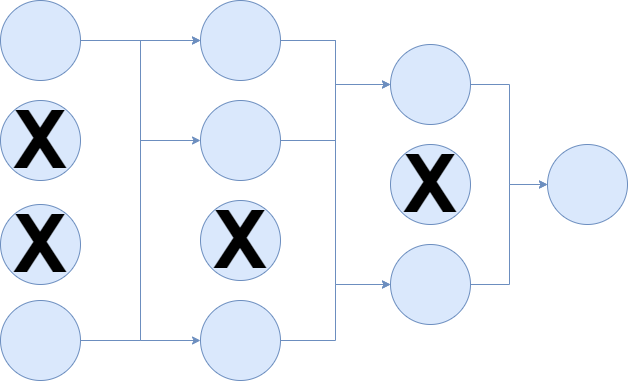 
  </br>
  * `Dense layer` : Let's see what this will look like.</br>
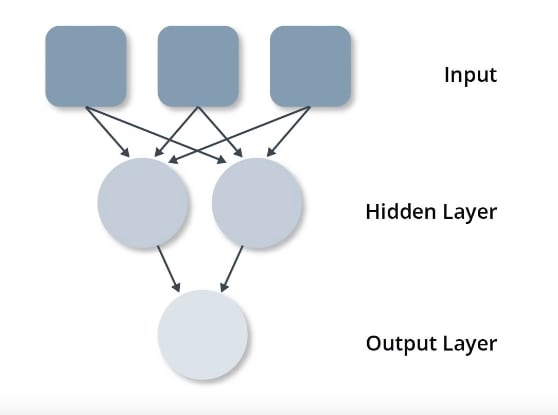
</br>

    These types of layers are fully connected or dense layers. So when we use a dense layer in keras , we're simply stating that the neurons in that layer are fully connected to the neurons in the previous layer.

  * <u>Sequence model :</u>
    * `Input layer` : This as an input shape of `(max_len,)` corresponding to the length of the maximum sentence.

    * `Embedding layer` : A word embedding is a class of approaches for representing words and documents using a dense vector representation.. It requires that the input data be integer encoded, so that each word is represented by a unique integer. This data preparation step can be performed using the Tokenizer API also provided with Keras.

      The Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training dataset.

      It is a flexible layer that can be used in a variety of ways, such as:

      * It can be used alone to learn a word embedding that can be saved and used in another model later.
      * It can be used as part of a deep learning model where the embedding is learned along with the model itself.
      * It can be used to load a pre-trained word embedding model, a type of transfer learning.
    
    * `LSTM layer` : An LSTM layer above provides a sequence output rather than a single value output to the LSTM layer below. Specifically, one output per input time step, rather than one output time step for all input time steps.</br>
    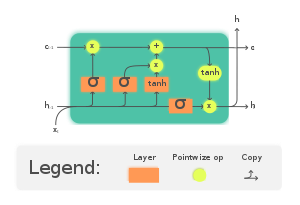

In [ ]:
# Feature extractor model
input_1     = Input(shape=(2048,))
droplayer   = Dropout(0.5)(input_1)
denselayer  = Dense(256, activation='relu')(droplayer)

# Sequence model
input_2     = Input(shape=(max_length,))
embedding   = Embedding(vocab_size, embedding_dim, mask_zero=True)(input_2)
droplayer_  = Dropout(0.5)(embedding)
lstm        = LSTM(256)(droplayer_)

# Decoder model
decoder1 = add([denselayer, lstm])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Optimizer 
optimizer   = Adam()

# Tie it together [image, seq] [word]
model = Model(inputs=[input_1, input_2], 
              outputs=outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 200)      420200      input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
______________________________________________________________________________________________

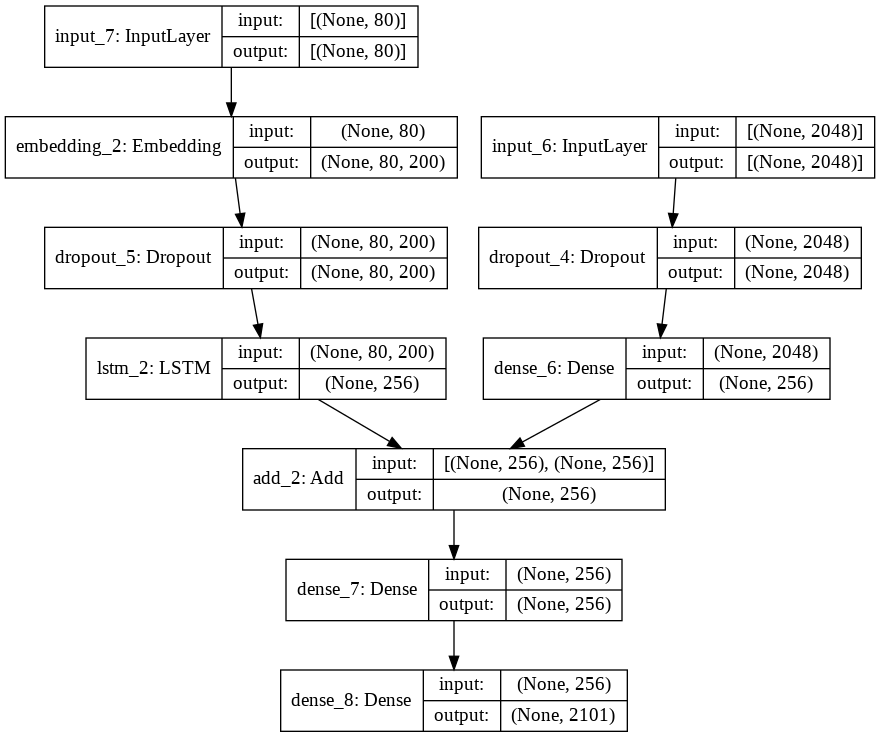

In [ ]:
fn_model = FLICKR_PATH_DIR_8K_5C_METHOD2_MODEL + "model.png"
plot_model(model, to_file=fn_model, show_shapes=True)

Input_7 is the partial caption of max length 80 which is fed into the embedding layer. This is where the words are mapped to the 200-d Glove embedding. It is followed by a dropout of 0.5 to avoid overfitting. This is then fed into the LSTM for processing the sequence.

Input_6 is the image vector extracted by our InceptionV3 network. It is followed by a dropout of 0.5 to avoid overfitting and then fed into a Fully Connected layer.

Both the Image model and the Language model are then concatenated by adding and fed into another Fully Connected layer. The layer is a softmax layer that provides probabilities to our 2101 word vocabulary.

# 5 - Model Training

Before training the model we need to keep in mind that we do not want to retrain the weights in our embedding layer (pre-trained Glove vectors).

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

Next, compile the model using Categorical_Crossentropy as the Loss function and Adam as the optimizer.

In [ ]:
model.compile(loss      = 'categorical_crossentropy', 
              optimizer = optimizer,
              metrics   = ["accuracy"])

Since our dataset has 6000 images and 40000 captions we will create a function that can train the data in batches.

In [ ]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
print(model.metrics)

[]


Next, let’s train our model for 30 epochs with batch size of 3 and 2000 steps per epoch.

If we have already trained our model,load the latest checkpoints.

In [ ]:
checkpoint_path = FLICKR_PATH_DIR_8K_5C_METHOD2_MODEL_CHECKPOINTS_DIR + "first_training/" + "model-ep30.ckpt"

# Since my model has already been trained, we lead the weight using the checkpoints
model.load_weights(checkpoint_path)

In [ ]:
epochs = 30
batch_size = 3
steps = len(train_descriptions)//batch_size

# Define checkpoint callback
fn_model_sentence_generation = FLICKR_PATH_DIR_8K_5C_METHOD2_MODEL_CHECKPOINTS_DIR + "second_training/" + 'model-ep{epoch:02d}.ckpt'

model_checkpoint_callback = ModelCheckpoint(filepath          = fn_model_sentence_generation, 
                                            monitor           = 'accuracy', 
                                            mode              = 'max',
                                            save_best_only    = True,
                                            save_weights_only = True) 

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)

model.fit(generator, 
          steps_per_epoch = steps, 
          verbose         = 1, 
          epochs          = epochs, 
          callbacks       = [model_checkpoint_callback])

Let's save our model. The `.h5f5` format can be loaded without knowing the model architecture as opposed to the `.ckpt`.

In [ ]:
filepath_model = FLICKR_PATH_DIR_8K_5C_METHOD2_MODEL_CHECKPOINTS_DIR + "second_training/"  + "latest_model_epoch30.h5"
filepath_history = FLICKR_PATH_DIR_8K_5C_METHOD2_MODEL_CHECKPOINTS_DIR + "second_training/"  + "latest_model_history.pkl"
# Saving the model with last parameter 
model.save(filepath_model)

# Save history of the model
dump(model.history.history, open(filepath_history, 'wb'))

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Let's plot our `model.history.history` that contains the informations about `loss` and `accuracy`.

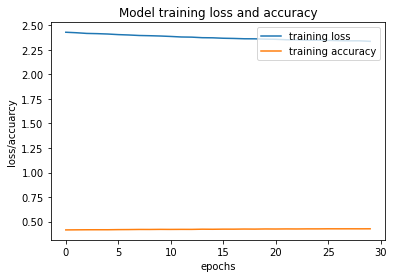

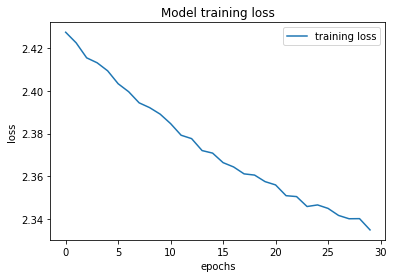

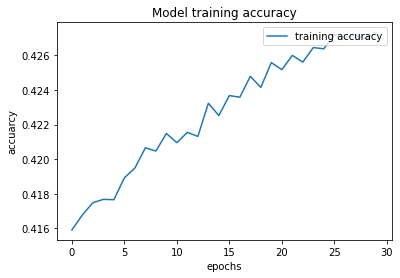

In [ ]:
# Plot training loss and accuracy
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['accuracy'])
plt.title('Model training loss and accuracy')
plt.ylabel('loss/accuarcy')
plt.xlabel('epochs')
plt.legend(['training loss', 'training accuracy'], loc='upper right')

# Save the figure of model training loss and accuracy
filename_model_history_loss_acc = FLICKR_PATH_DIR_8K_5C_METHOD2_MODEL_CHECKPOINTS_DIR + "second_training/" + "latest_model_history_loss_acc.jpg"
plt.savefig(filename_model_history_loss_acc)

# Show the rigure
plt.show()

# Plot training loss only
plt.plot(model.history.history['loss'])
plt.title('Model training loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training loss'], loc='upper right')

# Save the figure of model training loss and accuracy
filename_model_history_loss = FLICKR_PATH_DIR_8K_5C_METHOD2_MODEL_CHECKPOINTS_DIR + "second_training/" + "latest_model_history_loss.jpg"
plt.savefig(filename_model_history_loss)

# Show the rigure
plt.show()

# Plot training accuracy only
plt.plot(model.history.history['accuracy'])
plt.title('Model training accuracy')
plt.ylabel('accuarcy')
plt.xlabel('epochs')
plt.legend(['training accuracy'], loc='upper right')

# Save the figure of model training loss and accuracy
filename_model_history_acc = FLICKR_PATH_DIR_8K_5C_METHOD2_MODEL_CHECKPOINTS_DIR + "second_training/" + "latest_model_history_acc.jpg"
plt.savefig(filename_model_history_acc)

# Show the figure
plt.show()

<u>Observations</u> :
* The training curves indicates that the model needs to be learned more time but also that the model may nt be suitted to the dataset or the inverse. In the same way, when a model learns to enough, this can be a cause of underfitting.

# 6 - Greedy and Beam Search

As the model generates a 2101 long vector with a probability distribution across all the words in the vocabulary we greedily pick the word with the highest probability to get the next word prediction. This method is called Greedy Search.

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

Beam Search is where we take top k predictions, feed them again in the model and then sort them using the probabilities returned by the model. So, the list will always contain the top k predictions and we take the one with the highest probability and go through it till we encounter ‘endseq’ or reach the maximum caption length.

In [ ]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

# 7 - Testing 

Let’s now test our model on different images and see what captions it generates. We will also look at the different captions generated by Greedy search and Beam search with different k values.

First, we will take a look at an example image which is the first comment and image in the dataset. The caption of the image is `"two young guys with shaggy hair look at their hands while hanging out in the yard ."`

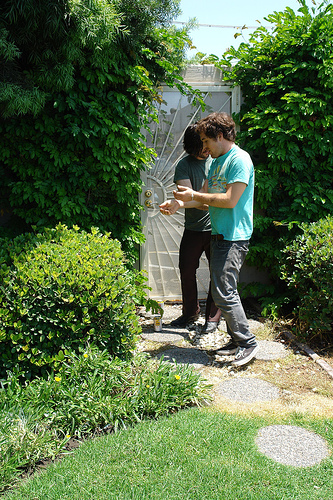

In [ ]:
# Display one image
Image(FLICKR_PATH_DIR + flickr_csv["image_name"][0])

In [ ]:
# Display the first comment (caption) of the above image
flickr_csv["comment"][0] 

'two young guys with shaggy hair look at their hands while hanging out in the yard .'

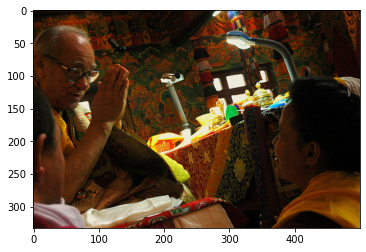

Greedy Search: a woman in a white shirt and blue hat is talking to a man in a black shirt
Beam Search, K = 3: a man in an orange shirt is talking to a woman in a blue shirt
Beam Search, K = 5: a woman in a blue shirt is talking to a group of teenage people
Beam Search, K = 7: a group of people sitting at a picnic table
Beam Search, K = 10: a group of people smile at each other


In [ ]:
image_name = flickr_csv["image_name"][30000]
image = encoding_test[image_name].reshape((1,2048))
x=plt.imread(FLICKR_PATH_DIR+image_name)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

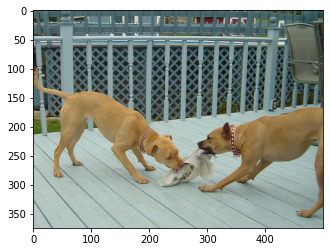

Greedy Search: a brown dog is running through the grass
Beam Search, K = 3: a black and white dog is running through the grass
Beam Search, K = 5: a brown and white dog running through pole
Beam Search, K = 7: a brown and white dog playing with a toy in its mouth
Beam Search, K = 10: a brown and white dog playing with a toy in its mouth


In [ ]:
image_name = flickr_csv["image_name"][30005]
image = encoding_test[image_name].reshape((1,2048))
x=plt.imread(FLICKR_PATH_DIR+image_name)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

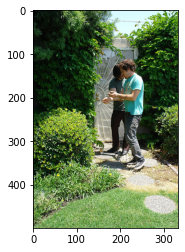

Greedy Search: a young boy in a blue shirt and blue jeans is playing with a blue balloon
Beam Search, K = 3: a man in a blue shirt is throwing a golf club pit
Beam Search, K = 5: a man in a blue shirt is throwing a golf club club
Beam Search, K = 7: a little girl in a white dress is standing in front of a garden rainbow
Beam Search, K = 10: a young boy wearing a blue shirt and blue jeans is standing in front of a chain link fence


In [ ]:
image_name = flickr_csv["image_name"][0]
image = encoding_train[image_name].reshape((1,2048))
x=plt.imread(FLICKR_PATH_DIR+image_name)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

# 8 - Testing by importing the pre-trained model

In order to test our model without for hours and thus make preductions over the images  and train again the model, follow these steps :
* Run all the cell except thoses who make oredictions on images and store data 
* Run the following cells

In [ ]:
filepath_model = FLICKR_PATH_DIR_8K_5C_METHOD2_MODEL_CHECKPOINTS_DIR + "second_training/"  + "latest_model_epoch30.h5"

# Recreate the exact same model, including its weights and the optimizer
model = load_model(filepath_model)

# Show the model architecture
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 80)]         0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 80, 200)      420200      input_29[0][0]                   
__________________________________________________________________________________________________
dropout_26 (Dropout)            (None, 2048)         0           input_28[0][0]                   
___________________________________________________________________________________________

In [ ]:
# Load the Model back from file
filename_encoding_train = FLICKR_PATH_DIR_8K_5C_METHOD2 + 'encoding_train' + "30-05-2021_13-47-28" + '.pkl'
filename_encoding_test = FLICKR_PATH_DIR_8K_5C_METHOD2 + 'encoding_test' + "30-05-2021_13-47-28" + '.pkl'

with open(filename_encoding_train, 'rb') as file: 
    encoding_train = pickle.load(file)
with open(filename_encoding_test, 'rb') as file: 
    encoding_test = pickle.load(file)

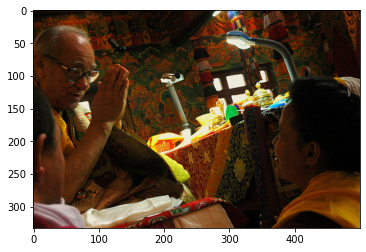

Greedy Search: a woman in a white shirt and blue hat is talking to a man in a black shirt
Beam Search, K = 3: a man in an orange shirt is talking to a woman in a blue shirt
Beam Search, K = 5: a woman in a blue shirt is talking to a group of teenage people
Beam Search, K = 7: a group of people sitting at a picnic table
Beam Search, K = 10: a group of people smile at each other


In [ ]:
image_name = flickr_csv["image_name"][30000]
image = encoding_test[image_name].reshape((1,2048))
x=plt.imread(FLICKR_PATH_DIR+image_name)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

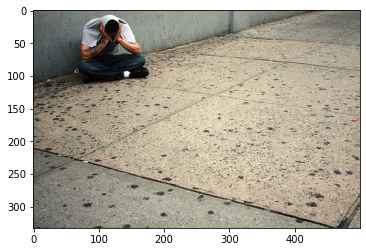

Greedy Search: a man in a blue shirt is kissing a woman in a black jacket
Beam Search, K = 3: a man in an orange shirt and blue jeans is standing in front of a building with graffiti painted in the background
Beam Search, K = 5: a man in an orange shirt and blue jeans is standing in front of a stone building
Beam Search, K = 7: a man in an orange shirt and blue jeans is standing in front of a stone building
Beam Search, K = 10: a man in an orange shirt is standing in front of what appears to be a building with graffiti painted


In [ ]:
image_name = flickr_csv["image_name"][39999]
image = encoding_test[image_name].reshape((1,2048))
x=plt.imread(FLICKR_PATH_DIR+image_name)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

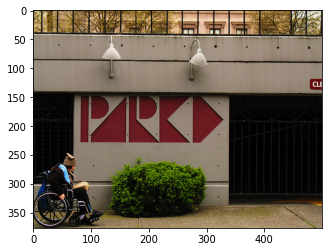

Greedy Search: a man in a suit is walking down the sidewalk
Beam Search, K = 3: a group of people enter a building
Beam Search, K = 5: a man in a blue shirt is standing in front of a building with graffiti painted
Beam Search, K = 7: a man and a woman are standing in front of a tall building
Beam Search, K = 10: a man and a woman are standing in front of a red building


In [ ]:
image_name = flickr_csv["image_name"][30050]
image = encoding_test[image_name].reshape((1,2048))
x=plt.imread(FLICKR_PATH_DIR+image_name)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

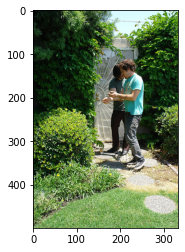

Greedy Search: a young boy in a blue shirt and blue jeans is playing with a blue balloon
Beam Search, K = 3: a man in a blue shirt is throwing a golf club pit
Beam Search, K = 5: a man in a blue shirt is throwing a golf club club
Beam Search, K = 7: a little girl in a white dress is standing in front of a garden rainbow
Beam Search, K = 10: a young boy wearing a blue shirt and blue jeans is standing in front of a chain link fence


In [ ]:
image_name = flickr_csv["image_name"][0]
image = encoding_train[image_name].reshape((1,2048))
x=plt.imread(FLICKR_PATH_DIR+image_name)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

In [ ]:
for comment in flickr_csv["comment"][:5]:
  print(comment)

two young guys with shaggy hair look at their hands while hanging out in the yard .
two young , white males are outside near many bushes .
two men in green shirts are standing in a yard .
a man in a blue shirt standing in a garden .
two friends enjoy time spent together .


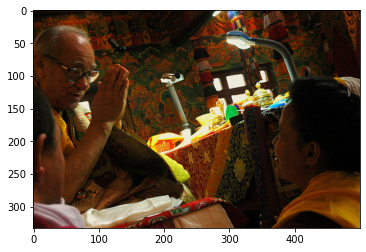

Greedy Search: a woman in a white shirt and blue hat is talking to a man in a black shirt
Beam Search, K = 3: a man in an orange shirt is talking to a woman in a blue shirt
Beam Search, K = 5: a woman in a blue shirt is talking to a group of teenage people
Beam Search, K = 7: a group of people sitting at a picnic table
Beam Search, K = 10: a group of people smile at each other


In [ ]:
image_name = flickr_csv["image_name"][30000]
image = encoding_test[image_name].reshape((1,2048))
x=plt.imread(FLICKR_PATH_DIR+image_name)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

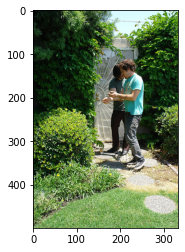

Greedy Search: a young boy in a blue shirt and blue jeans is playing with a blue balloon
Beam Search, K = 3: a man in a blue shirt is throwing a golf club pit
Beam Search, K = 5: a man in a blue shirt is throwing a golf club club
Beam Search, K = 7: a little girl in a white dress is standing in front of a garden rainbow
Beam Search, K = 10: a young boy wearing a blue shirt and blue jeans is standing in front of a chain link fence


In [ ]:
image_name = flickr_csv["image_name"][0]
image = encoding_train[image_name].reshape((1,2048))
x=plt.imread(FLICKR_PATH_DIR+image_name)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

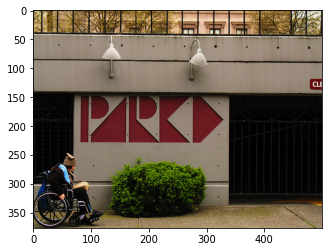

Greedy Search: a man in a suit is walking down the sidewalk
Beam Search, K = 3: a group of people enter a building
Beam Search, K = 5: a man in a blue shirt is standing in front of a building with graffiti painted
Beam Search, K = 7: a man and a woman are standing in front of a tall building
Beam Search, K = 10: a man and a woman are standing in front of a red building


In [ ]:
image_name = flickr_csv["image_name"][30050]
image = encoding_test[image_name].reshape((1,2048))
x=plt.imread(FLICKR_PATH_DIR+image_name)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

<u>Way to improve the project</u> :
* Use lemmatizing
* Bind the lematizing and the images with a model to have a contexte
* Use this context with the sentences to  generate a sentence 
